In [1]:
!kaggle datasets download -d prashant268/chest-xray-covid19-pneumonia

Dataset URL: https://www.kaggle.com/datasets/prashant268/chest-xray-covid19-pneumonia
License(s): unknown
 99% 2.04G/2.06G [00:13<00:00, 164MB/s]
100% 2.06G/2.06G [00:13<00:00, 158MB/s]


In [2]:
!unzip chest-xray-covid19-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: Data/train/COVID19/COVID19(228).jpg  
  inflating: Data/train/COVID19/COVID19(229).jpg  
  inflating: Data/train/COVID19/COVID19(23).jpg  
  inflating: Data/train/COVID19/COVID19(230).jpg  
  inflating: Data/train/COVID19/COVID19(231).jpg  
  inflating: Data/train/COVID19/COVID19(232).jpg  
  inflating: Data/train/COVID19/COVID19(233).jpg  
  inflating: Data/train/COVID19/COVID19(234).jpg  
  inflating: Data/train/COVID19/COVID19(235).jpg  
  inflating: Data/train/COVID19/COVID19(236).jpg  
  inflating: Data/train/COVID19/COVID19(237).jpg  
  inflating: Data/train/COVID19/COVID19(238).jpg  
  inflating: Data/train/COVID19/COVID19(239).jpg  
  inflating: Data/train/COVID19/COVID19(24).jpg  
  inflating: Data/train/COVID19/COVID19(240).jpg  
  inflating: Data/train/COVID19/COVID19(241).jpg  
  inflating: Data/train/COVID19/COVID19(242).jpg  
  inflating: Data/train/COVID19/COVID19(243).jpg  
  inflating: Data/train/COVID19/C

In [3]:
import os, shutil
import random
import numpy as np
import pandas as pd
import cv2
import skimage
import matplotlib.pyplot as plt
import skimage.segmentation
import seaborn as sns
from glob import glob
plt.style.use('ggplot')

In [4]:
train_path = '/content/Data/train'
test_path = '/content/Data/test'

In [5]:
classes = ['PNEUMONIA', 'NORMAL', 'COVID19']

In [6]:
def count_images(data_dir, classes):
    image_count = {}
    for cls in classes:
        image_count[cls] = len(glob(os.path.join(data_dir, cls, '*.jpg')))
    return image_count

In [7]:
train_count = count_images(train_path, classes)
test_count = count_images(test_path, classes)

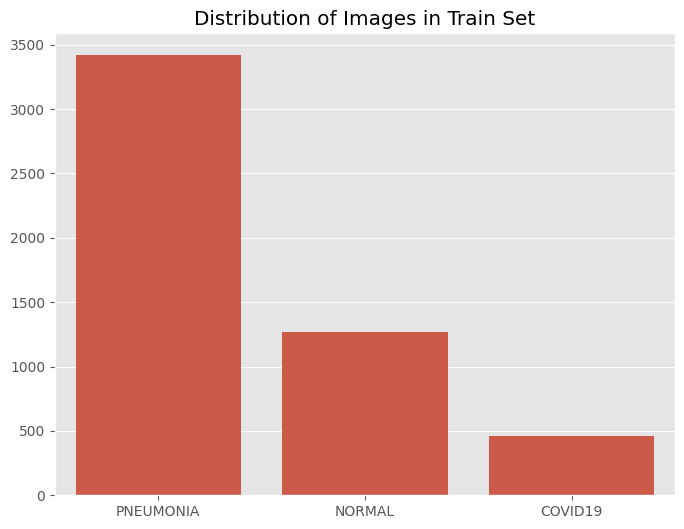

In [8]:
plt.figure(figsize=(8, 6))
sns.barplot(x=list(train_count.keys()), y=list(train_count.values()))
plt.title('Distribution of Images in Train Set')
plt.savefig('plot_train_data_distribution.png')
plt.show()

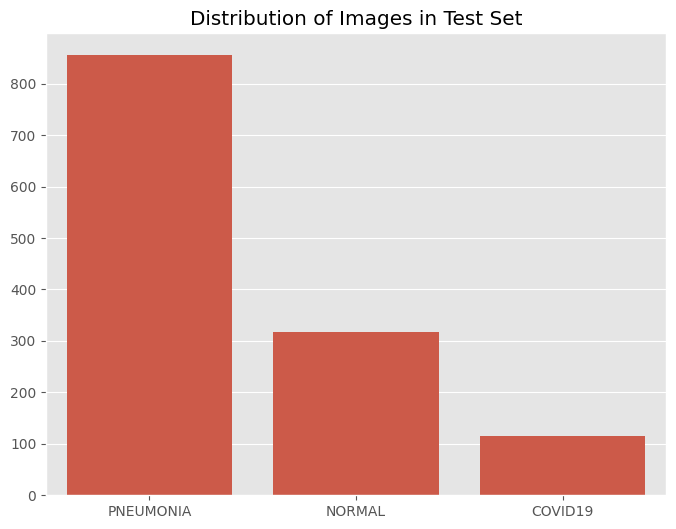

In [9]:
plt.figure(figsize=(8, 6))
sns.barplot(x=list(test_count.keys()), y=list(test_count.values()))
plt.title('Distribution of Images in Test Set')
plt.savefig('plot_test_data_distribution.png')
plt.show()

In [10]:
def plot_sample_images(data_dir, classes, n=3):
    fig, axes = plt.subplots(3, n, figsize=(12, 12))
    for i, cls in enumerate(classes):
        class_dir = os.path.join(data_dir, cls)
        images = glob(os.path.join(class_dir, '*.jpg'))
        for j in range(n):
            img = cv2.imread(images[j])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            axes[i, j].set_title(f'{cls}')
    plt.savefig('Sample_images_visualization.png')
    plt.show()



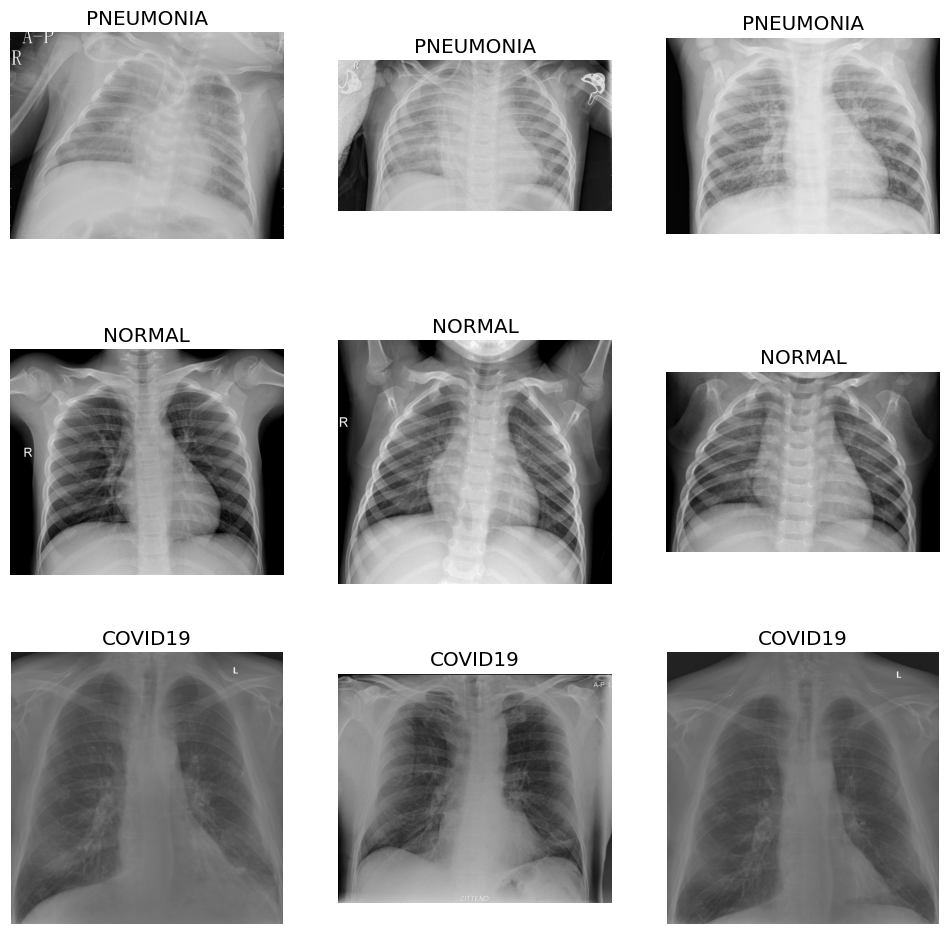

In [11]:
plot_sample_images(train_path, classes)

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [13]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

In [14]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [33]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=24,
    class_mode='categorical'  # Since there are 3 classes
)

Found 5144 images belonging to 3 classes.


In [34]:
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=24,
    class_mode='categorical'
)

Found 1288 images belonging to 3 classes.


In [17]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

In [35]:
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [19]:
model_resnet = Sequential([
    resnet,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 output classes for COVID19, NORMAL, PNEUMONIA
])

In [20]:
model_resnet.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [36]:
history_resnet = model_resnet.fit(
    train_generator,
    validation_data=test_generator,
    epochs=7,
    steps_per_epoch=train_generator.samples // 32,
    validation_steps=test_generator.samples // 32
)

Epoch 1/7
160/160 [==============================] - 260s 2s/step - loss: 0.1037 - accuracy: 0.9657 - val_loss: 0.4701 - val_accuracy: 0.8833
Epoch 2/7
160/160 [==============================] - 261s 2s/step - loss: 0.1243 - accuracy: 0.9610 - val_loss: 0.6484 - val_accuracy: 0.8771
Epoch 3/7
160/160 [==============================] - 262s 2s/step - loss: 0.1088 - accuracy: 0.9652 - val_loss: 1.1917 - val_accuracy: 0.8104
Epoch 4/7
160/160 [==============================] - 261s 2s/step - loss: 0.0974 - accuracy: 0.9682 - val_loss: 0.1482 - val_accuracy: 0.9521
Epoch 5/7
160/160 [==============================] - 260s 2s/step - loss: 0.0842 - accuracy: 0.9758 - val_loss: 0.0860 - val_accuracy: 0.9677
Epoch 6/7
160/160 [==============================] - 258s 2s/step - loss: 0.0879 - accuracy: 0.9738 - val_loss: 0.1374 - val_accuracy: 0.9667
Epoch 7/7
160/160 [==============================] - 259s 2s/step - loss: 0.1195 - accuracy: 0.9746 - val_loss: 190.3386 - val_accuracy: 0.7031


In [37]:
model_resnet.save('resnet_pneumonia_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# prompt: Zip all the images and models saved

!zip -r results.zip *.png *.h5


updating: plot_test_data_distribution.png (deflated 27%)
updating: plot_train_data_distribution.png (deflated 26%)
updating: Sample_images_visualization.png (deflated 3%)
updating: resnet_pneumonia_model.h5

In [ ]:
def plot_history(history, model_name):
    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='train accuracy')
    plt.plot(history.history['val_accuracy'], label='val accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.title(f'{model_name} Loss')
    plt.legend()

    plt.savefig(f'{model_name}_history.png')
    plt.show()

In [ ]:
plot_history(history_resnet, 'ResNet')

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved ResNet model
model_resnet = load_model('resnet_pneumonia_model.h5')

In [ ]:
predictions = model_resnet.predict(test_generator)

# Get predicted class labels
predicted_classes = predictions.argmax(axis=-1)

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [ ]:
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Generate a confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.savefig('Confusion_matrix.png')
plt.show()

In [ ]:
!zip -r results.zip *.png *.h5